In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
inf_gb_throw_df = pd.read_csv('../../data/derived/plays/inf_gb_with_throw_1b_df.csv').drop(columns='Unnamed: 0')
game_events_df = pd.read_csv('../../data/combined/game_events.csv').drop(columns='Unnamed: 0')
game_info_df = pd.read_csv('../../data/combined/game_info.csv').drop(columns='Unnamed: 0')
player_pos_df = pd.read_csv('../../data/combined/player_pos.csv').drop(columns='Unnamed: 0')

In [14]:
# Grab all unique IDs who fielded a ball and threw to first base
fielder_ids = inf_gb_throw_df.merge(game_info_df, how='inner', on=['game_str', 'play_per_game'])
pos_dict = {1:'pitcher', 2:'catcher', 3:'first_base', 4:'second_base', 5:'third_base', 6:'shortstop'}
fielder_ids['player_id'] = fielder_ids.apply(lambda row: row[pos_dict[row['player_position']]], axis=1)
fielder_ids = fielder_ids['player_id'].unique()
print(f'Num unique fielders: {len(fielder_ids)}')

# Grab all times those unique IDs hit a ball into play to record their max speed
hit_into_play_df = game_events_df.loc[game_events_df['event_code'] == 4, ['game_str', 'at_bat', 'play_id', 'timestamp']]
hit_into_play_df.rename(columns={'timestamp':'timestamp_contact'}, inplace=True)
hit_into_play_df = hit_into_play_df.merge(game_info_df, how='inner', on=['game_str', 'at_bat'])

fielder_contact = hit_into_play_df.loc[hit_into_play_df['batter'].isin(fielder_ids)]
fielder_contact = fielder_contact[['game_str', 'play_id', 'batter', 'timestamp_contact']]
print(f'Num fielders who made contact: {fielder_contact["batter"].nunique()}')

# Grab the positions of players on plays where a ID of interest made contact
fielder_contact = fielder_contact.merge(player_pos_df, how='inner', on=['game_str', 'play_id'])
# Filter for batter's positions only
fielder_contact = fielder_contact.loc[fielder_contact['player_position'] == 10]

# Only keep position of player from the moment they made contact and beyond
fielder_contact = fielder_contact.loc[fielder_contact['timestamp'] >= fielder_contact['timestamp_contact']]

fielder_contact.head(10)

Num unique fielders: 155
Num fielders who made contact: 155


,game_str,play_id,batter,timestamp_contact,timestamp,player_position,field_x,field_y
1907,1903_01_TeamNE_TeamA2,12,9762,227099,227099.0,10,3.1005,0.0612
1908,1903_01_TeamNE_TeamA2,12,9762,227099,227132.0,10,3.0828,0.0714
1909,1903_01_TeamNE_TeamA2,12,9762,227099,227165.0,10,3.0654,0.0816
1910,1903_01_TeamNE_TeamA2,12,9762,227099,227198.0,10,3.0480,0.0915
1911,1903_01_TeamNE_TeamA2,12,9762,227099,227231.0,10,3.0303,0.1011
1912,1903_01_TeamNE_TeamA2,12,9762,227099,227264.0,10,3.0126,0.1110
1913,1903_01_TeamNE_TeamA2,12,9762,227099,227297.0,10,2.9952,0.1206
1914,1903_01_TeamNE_TeamA2,12,9762,227099,227330.0,10,2.9772,0.1302
1915,1903_01_TeamNE_TeamA2,12,9762,227099,227363.0,10,2.9595,0.1398
1916,1903_01_TeamNE_TeamA2,12,9762,227099,227396.0,10,2.9415,0.1494


Number of fielders with a max speed: 155
count    155.000000
mean      30.047773
std       26.461371
min       16.757439
25%       20.098881
50%       23.505408
75%       27.259112
max      156.333264
Name: max_speed, dtype: float64


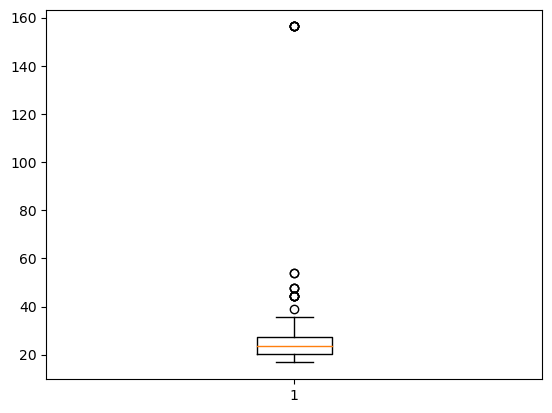

count    137.000000
mean      23.097219
std        3.994711
min       16.757439
25%       20.017325
50%       22.097680
75%       25.932343
max       35.442264
Name: max_speed, dtype: float64


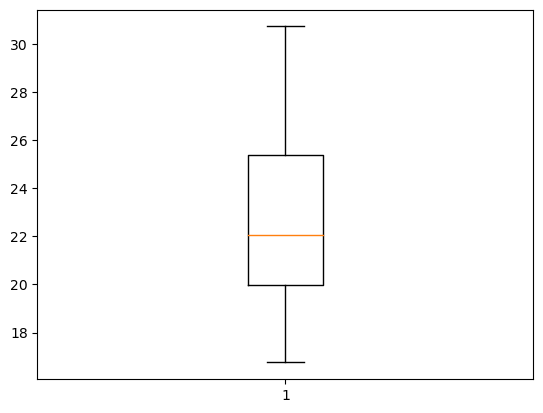

,batter,max_speed
0,1080,24.839231
1,1119,27.418296
2,1144,24.776584
3,1181,27.153289
4,1258,26.489183


In [15]:
def calculate_max_speed_on_play(group):
    max_speed = 0.0
    pos_1 = np.array([group['field_x'].iloc[0], group['field_y'].iloc[0]])
    time_1 = group['timestamp'].iloc[0]

    i = 1
    while i < len(group):
        time_2 = group['timestamp'].iloc[i]
        delta_time = time_2 - time_1
        if delta_time < 100:
            i += 1
        else:
            pos_2 = np.array([group['field_x'].iloc[i], group['field_y'].iloc[i]])
            speed = np.linalg.norm(pos_2 - pos_1) / delta_time
            if speed > max_speed:
                max_speed = speed
            pos_1 = pos_2
            time_1 = time_2
            i += 1
    return pd.Series({'max_speed': max_speed})

# Calculate the max speed for each play and player
fielder_max_speed = fielder_contact.groupby(['game_str', 'play_id', 'batter']).apply(calculate_max_speed_on_play).reset_index()
fielder_max_speed = fielder_max_speed.groupby('batter')['max_speed'].max()
fielder_max_speed_df = pd.DataFrame(fielder_max_speed).reset_index()

fielder_max_speed_df['max_speed'] = fielder_max_speed_df['max_speed'] * 0.681818 * 1000
print(f'Number of fielders with a max speed: {fielder_max_speed_df["batter"].nunique()}')
print(fielder_max_speed_df['max_speed'].describe())

# Create a box and whisker plot of the max speeds, then use the 1.5 IQR to filter outliers. Describe the data again, make another plot.
plt.boxplot(fielder_max_speed_df['max_speed'])
plt.show()

# Filter outliers
q1 = fielder_max_speed_df['max_speed'].quantile(0.25)
q3 = fielder_max_speed_df['max_speed'].quantile(0.75)
iqr = q3 - q1

fielder_max_speed_df = fielder_max_speed_df.loc[(fielder_max_speed_df['max_speed'] >= q1 - 1.5 * iqr) &
                                                (fielder_max_speed_df['max_speed'] <= q3 + 1.5 * iqr)]

print(fielder_max_speed_df['max_speed'].describe())

# Noticing an outlier, remove the person above 31 mph
fielder_max_speed_df = fielder_max_speed_df.loc[fielder_max_speed_df['max_speed'] < 31]

plt.boxplot(fielder_max_speed_df['max_speed'])
plt.show()

fielder_max_speed_df.to_csv('../../data/derived/fielderspeed/fielder_max_speed_df.csv')

# Display the calculated max speeds
fielder_max_speed_df.head()

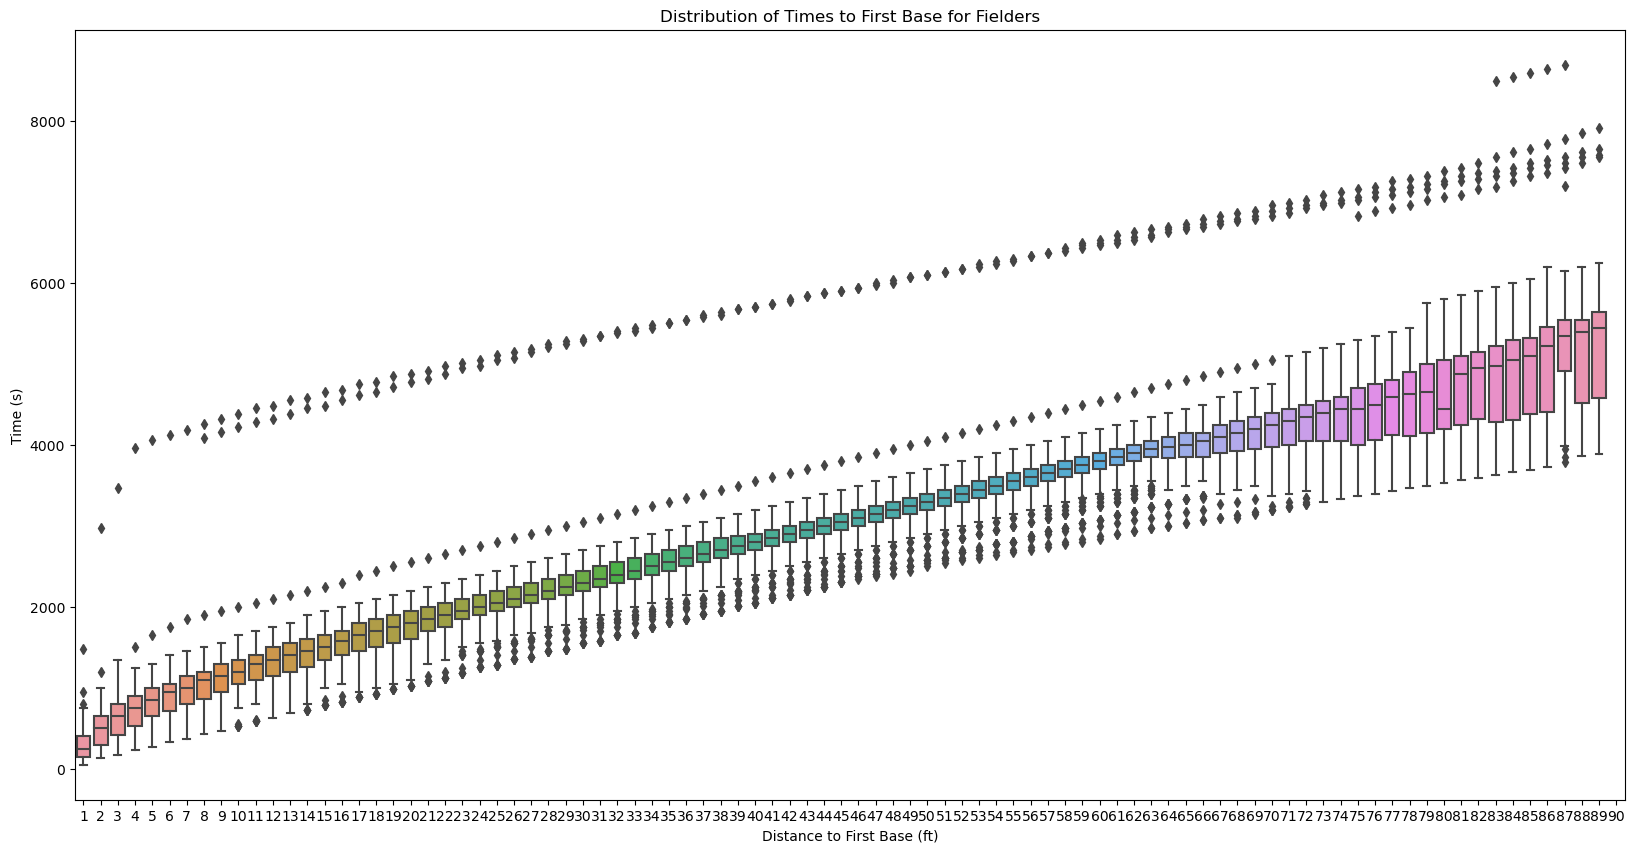

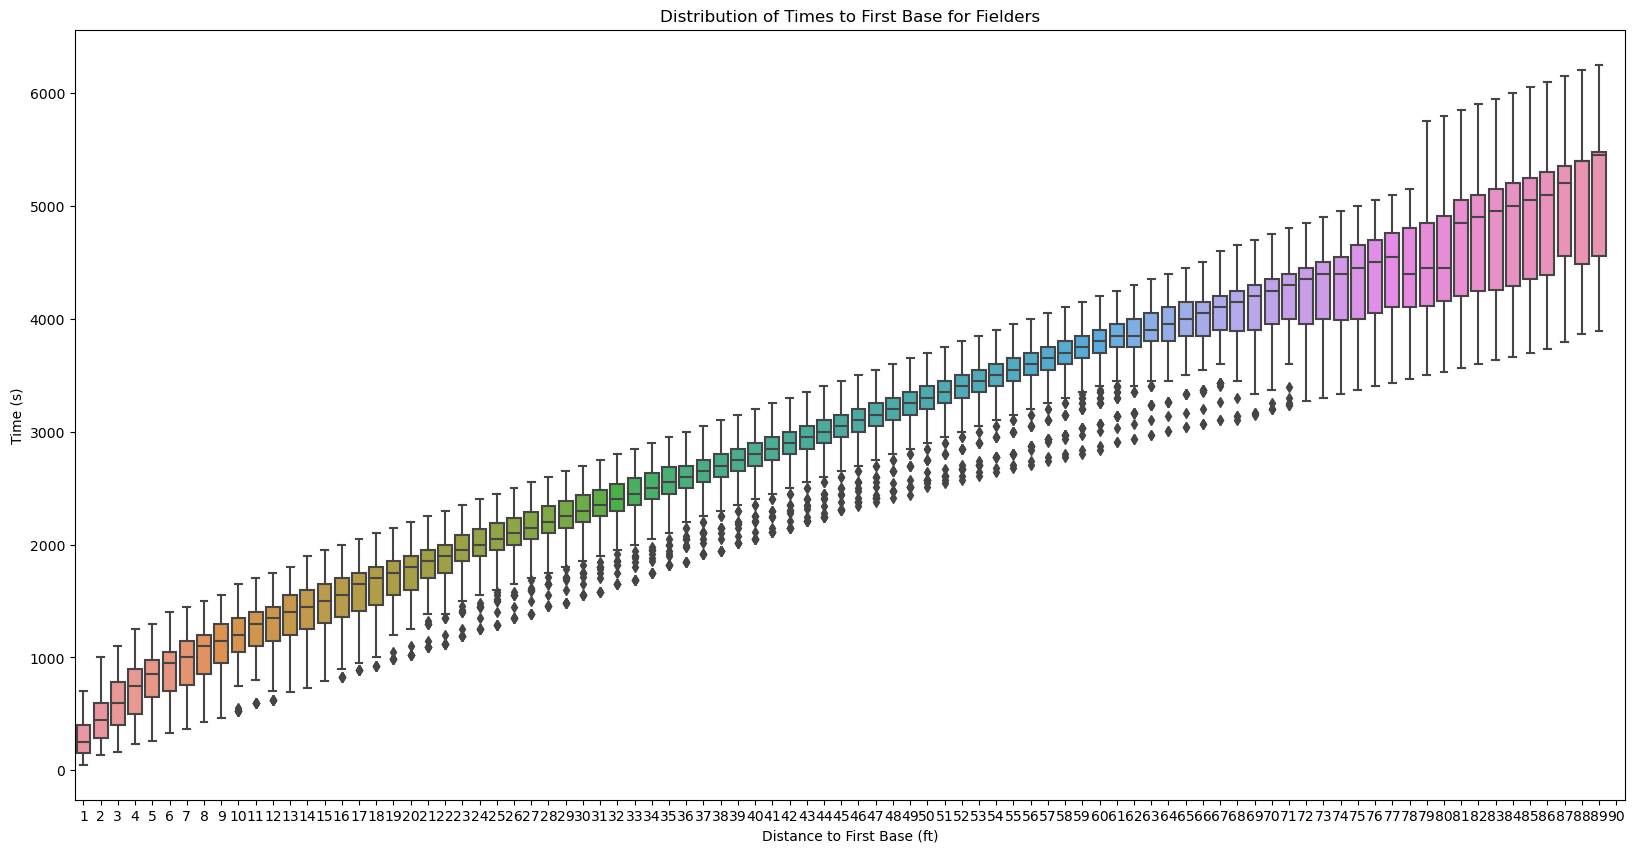

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
9762,500.0,650.0,750.0,850.0,950.0,1050.0,1150.0,1200.0,1300.0,1350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972,200.0,400.0,550.0,700.0,750.0,800.0,850.0,900.0,950.0,1050.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2053,150.0,250.0,400.0,500.0,650.0,750.0,900.0,1000.0,1150.0,1250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1297,150.0,250.0,350.0,450.0,550.0,650.0,700.0,750.0,850.0,900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382,150.0,250.0,400.0,500.0,650.0,750.0,900.0,1000.0,1100.0,1200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def calculate_best_times(group, best_sub_90_times_df):
    start_pos = np.array([group['field_x'].iloc[0], group['field_y'].iloc[0]])
    start_time = group['timestamp'].iloc[0]
    
    i = 0
    curr_dist = 0
    while i < len(group):
        # Calculate the distance between the start position and current position
        curr_pos = np.array([group['field_x'].iloc[i], group['field_y'].iloc[i]])
        dist = np.linalg.norm(curr_pos - start_pos)

        if dist > 90:
            break
        
        delta_time = group['timestamp'].iloc[i] - start_time
        # Update the best_sub_90_times_df if the current time is the new minimum
        if dist > curr_dist + 1 and delta_time < best_sub_90_times_df.loc[group['batter'].iloc[0], str(curr_dist + 1)]:
            # print(group['batter'].iloc[0], curr_dist + 1, delta_time)
            best_sub_90_times_df.loc[group['batter'].iloc[0], str(curr_dist + 1)] = delta_time
            curr_dist += 1
        i += 1

# Create columns 1-90 as strings
player_ids = fielder_contact['batter'].unique()
best_sub_90_times_df = pd.DataFrame(index=player_ids, columns=[str(i) for i in range(1, 91)])
best_sub_90_times_df = best_sub_90_times_df.fillna(float('inf'))  # Initialize with infinity

# Iterate over groups and calculate best times
grouped = fielder_contact.groupby(['game_str', 'play_id', 'batter'])
for group_name, group_df in grouped:
    calculate_best_times(group_df, best_sub_90_times_df)
    # print(f'{i} / {len(grouped)}')

# Replace inf values with NaN
best_sub_90_times_df.replace(float('inf'), np.nan, inplace=True)

fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=best_sub_90_times_df, ax=ax)
ax.set_title('Distribution of Times to First Base for Fielders')
ax.set_xlabel('Distance to First Base (ft)')
ax.set_ylabel('Time (s)')
plt.show()

# Use 1.5 IQR rule to remove outliers
Q1 = best_sub_90_times_df.quantile(0.25)
Q3 = best_sub_90_times_df.quantile(0.75)

IQR = Q3 - Q1
best_sub_90_times_df = best_sub_90_times_df[~((best_sub_90_times_df > (Q3 + 1.5 * IQR))).any(axis=1)]

fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=best_sub_90_times_df, ax=ax)
ax.set_title('Distribution of Times to First Base for Fielders')
ax.set_xlabel('Distance to First Base (ft)')
ax.set_ylabel('Time (s)')
plt.show()

# Write to csv with player_id column instead of index
best_sub_90_times_df.reset_index().to_csv('../../data/derived/fielderspeed/fielder_best_sub_90_times_df.csv')

best_sub_90_times_df.head()

In [7]:
# Write to csv with player_id column instead of index
best_sub_90_times_df.reset_index()
best_sub_90_times_df.rename(columns={'index':'player_id'}, inplace=True)
best_sub_90_times_df.to_csv('../../data/derived/fielderspeed/best_sub_90_times_df.csv')

In [10]:
best_sub_90_times_df = pd.read_csv('../../data/derived/fielderspeed/best_sub_90_times_df.csv').drop(columns='Unnamed: 0')

In [11]:
best_sub_90_times_df.head()

,player_id,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,9762,500.0,650.0,750.0,850.0,950.0,1050.0,1150.0,1200.0,1300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972,200.0,400.0,550.0,700.0,750.0,800.0,850.0,900.0,950.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2053,150.0,250.0,400.0,500.0,650.0,750.0,900.0,1000.0,1150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1297,150.0,250.0,350.0,450.0,550.0,650.0,700.0,750.0,850.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2382,150.0,250.0,400.0,500.0,650.0,750.0,900.0,1000.0,1100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
